In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne

from scipy import signal

In [2]:
""" 
written by: Emma Chen

Jupyter notebook to visualize MI-data collected using the DSI-7 for validation
"""

' \nwritten by: Emma Chen\n\nJupyter notebook to visualize MI-data collected using the DSI-7 for validation\n'

In [3]:
eeg     = np.loadtxt(r'C:\Users\emmac\OneDrive\Documents\GitHub\EEGTetris\dc\DSI-7_0210\devin_eeg.csv', delimiter=',', skiprows=1)
markers = np.loadtxt(r'C:\Users\emmac\OneDrive\Documents\GitHub\EEGTetris\dc\DSI-7_0210\devin_markers.csv', delimiter=',', skiprows=1)

Fs      = 300    # sampling rate of the DSI-7

In [4]:
eeg.shape

(35559, 9)

In [5]:
def eeg_chop(eeg, markers):
    """ Epochs EEG data collected using the DSI-7 according to original (mislabeled) paradigm
    (ie. data collected on 02/10)

    Parameters
    ----------
    eeg: np.arr (n, 9)
        EEG data where n = # of timepoints and 9 channels of recording
        1st channel is time (s) and the remaining 8 are (in order): F3, Fz, F4, C3, C4, P3, P4, Gnd
            Gnd will read as column of 0s, can ignore

    markers: np.arr (m, 2) 
        m/2 = no. of trials
        Consists of corresponding marker #. Markers mark start+end of MI prompt presentation
        Marker encoding can be found under utils.py
        Functions (get_marker_name) found in utils.py can also decode marker # as needed

    Returns
    -------
    labels: np.arr (m/2, 1)
        processed markers arr to include only 'MI_TYPE' markers for each trial        

    baseline: np.arr (m/2, Fs * 2, 9)
        'baseline' epoch for each trial; consists of 2s (600 datapoints) before MI prompt
        9 channels like eeg arr

    motor_im: np.arr (m/2, Fs * 4, 9)
        active motor imagining epoch for each trial; consists of 4s (1200 datapoints) after MI prompt ends
        9 channels like eeg arr
    """
    eeg_f = eeg.copy()
    eeg_f[:, 0] = ['{:.3f}'.format(value) for value in eeg[:, 0]]
    
    marker_strt = markers[::2, :]
    marker_stop = markers[1::2, :]

    labels   = np.empty((marker_strt.shape[0], 1))
    baseline = np.empty((marker_strt.shape[0], 300 * 2, 9))
    motor_im = np.empty((marker_strt.shape[0], 300 * 4, 9))
    
    for i in range(marker_strt.shape[0]):
        end_idx = np.where(eeg[:, 0] <= marker_strt[0, 0])[0][-1]
        labels[i] = marker_strt[i, 1]
        baseline[i] = eeg[end_idx - 300 * 2:end_idx]

    for i in range(marker_stop.shape[0]):
        start_idx = np.where(eeg[:, 0] >= marker_stop[i, 0])[0][0]
        motor_im[i] = eeg[start_idx:start_idx + 300 * 4]

    return labels, baseline, motor_im

In [6]:
labels, baseline, motor_im = eeg_chop(eeg, markers)

In [7]:
baseline.shape, baseline[0].shape

((8, 600, 9), (600, 9))

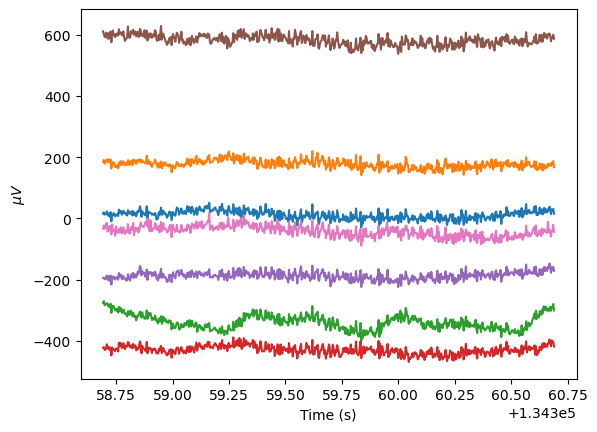

In [8]:
# Plotting 1st trial of baseline for vis. 
# 1st channel on x-axis (time)
# 8th channel excluded (gnd)

# You can see the DC offset present across the channels; signals are not centered at 0

t1 = baseline[0]

for i in range(1, 8):
    plt.plot(t1[:, 0], t1[:, i])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

C:\Users\emmac\AppData\Local\Temp\ipykernel_20448\1145856686.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  t1_ndc[:, i]     = ifft
c:\Users\emmac\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\emmac\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


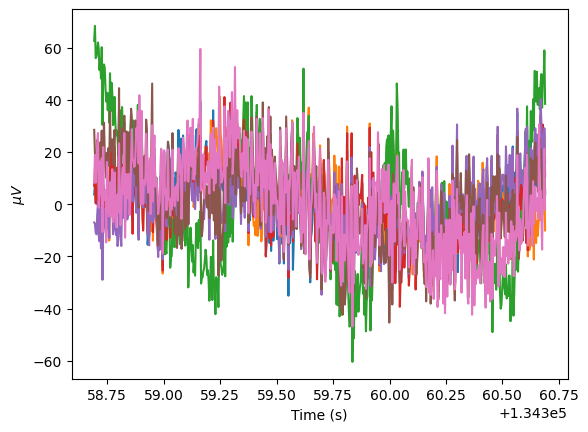

In [9]:
# Correct for DC offset in signal
# using t1 as small scale ex. to play with

# All channels are centered at 0 now, yay

t1_ndc = np.empty((t1.shape))
for i in range(1, 8):
    fft    = np.fft.fft(t1[:, i], axis=0)
    frq    = np.fft.fftfreq(t1.shape[0], 1/Fs)
    
    dcidx  = np.abs(frq).argmin()      # DC component of signal = coefficient of fft at 0 Hz
    fft[dcidx] = 0                     # mask to remove DC component

    ifft   = np.fft.ifft(fft, axis=0)  # inverse fft to return corrected signal
    t1_ndc[:, i]     = ifft
    
    plt.plot(t1[:, 0], ifft)           # plot

t1_ndc[:, 0] = t1[:, 0]

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

In [10]:
# lemme write a function to process the raw EEG signal as a whole
# ig, it's better to pre-process before epoching

def nodc(eeg, Fs):                                  # Read as 'no DC'
    """ Corrects for DC offset in EEG data

    Parameters
    ----------
    eeg: np.arr
        EEG data where the no. of rows = # of sampled timepoints and data channels are across column
        1st channel is time (s)

    Fs: int
        sampling rate

    Returns
    -------
    eeg_nodc: np.arr
        og. EEG data arr corrected for DC offset across channels
    """

    fft      = np.fft.fft(eeg[:, 1:], axis=0)       # Need to exclude 1st channel so you don't 'DC un-offset' time
    frq      = np.fft.fftfreq(eeg.shape[0], 1/Fs)

    dc_idx   = np.abs(frq).argmin()   
    fft[dc_idx] = 0  

    ifft     = np.fft.ifft(fft, axis=0)
    eeg_nodc = np.hstack((eeg[:, 0].reshape(-1, 1), ifft))

    return eeg_nodc

In [11]:
# Sanity check to make sure functions work together

eeg_nodc         = nodc(eeg, Fs)
eeg_nodc_chopped = eeg_chop(eeg_nodc, markers)

# You can ignore the complex number warnings

C:\Users\emmac\AppData\Local\Temp\ipykernel_20448\1473710880.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  baseline[i] = eeg[end_idx - 300 * 2:end_idx]
C:\Users\emmac\AppData\Local\Temp\ipykernel_20448\1473710880.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  motor_im[i] = eeg[start_idx:start_idx + 300 * 4]


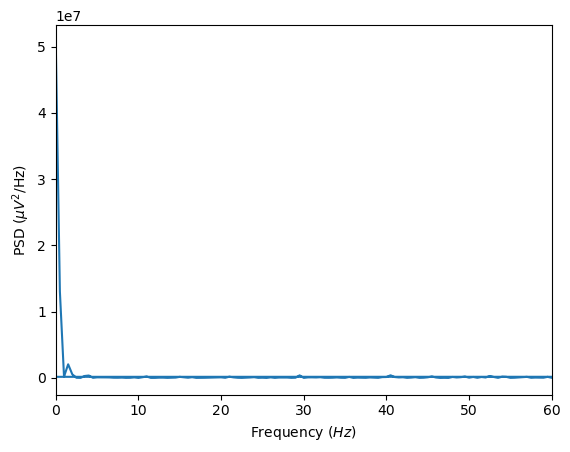

In [12]:
# Let's plot the power spectral density (PSD) of t1 for one channel

# As you can see, there's a lot of low-frequency noise that is obstructing our view 
# of frequencies in ranges we actually care about

t1_fft = np.fft.fft(t1[:, 1:], axis=0)
t1_frq = np.fft.fftfreq(t1.shape[0], 1/Fs)

plt.plot(t1_frq, np.abs(t1_fft[:, 0])**2)

plt.xlim(0, 60)

plt.xlabel(r'Frequency $(Hz)$')
plt.ylabel(r'PSD ($\mu V^2$/Hz)')

plt.show()

C:\Users\emmac\AppData\Local\Temp\ipykernel_20448\2237119994.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx((Fs * 0.5 / np.pi) * w, 20 * np.log10(abs(h)))


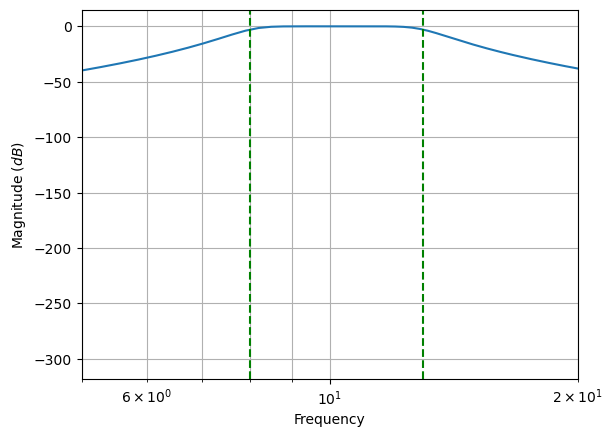

In [13]:
# let's design an alpha (8-13) bandpass filter
# I first tried a Butterworth filter because ChatGPT said it would be a good idea

sos = signal.butter(N=4, Wn=[8, 13], btype='band', fs=Fs, output='sos')
w, h = signal.sosfreqz(sos)       # 'w' is angular frequency, radians / second     

# we graph the frequency response of the filter to check if it is doing what we want it to
# 'gain' in dB on y-axis
plt.semilogx((Fs * 0.5 / np.pi) * w, 20 * np.log10(abs(h)))

# vertical lines to mark desired frequency bands
plt.axvline(8 , color='green', linestyle='--')
plt.axvline(13, color='green', linestyle='--')

plt.xlabel('Frequency')
plt.ylabel(r'Magnitude $(dB)$')

plt.xlim(5, 20)
plt.grid(which='both', axis='both')

plt.show()

# 0 dB gain btw. 8-13 indicates no frequency suppression-- which is good
# . . . but the gradual sloping shows poor attenuation of frequencies outside of the desired range

C:\Users\emmac\AppData\Local\Temp\ipykernel_20448\1914394559.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx((Fs * 0.5 / np.pi) * w, 20 * np.log10(abs(h)))


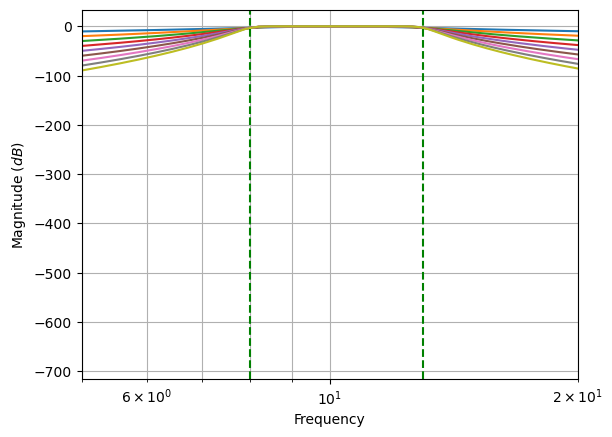

In [14]:
# we could try the same filter at different orders

for n in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    sos = signal.butter(N=n, Wn=[8, 13], btype='band', fs=Fs, output='sos')
    w, h = signal.sosfreqz(sos)      

    plt.semilogx((Fs * 0.5 / np.pi) * w, 20 * np.log10(abs(h)))


plt.axvline(8 , color='green', linestyle='--')
plt.axvline(13, color='green', linestyle='--')

plt.xlabel('Frequency')
plt.ylabel(r'Magnitude $(dB)$')

plt.xlim(5, 20)
plt.grid(which='both', axis='both')

plt.show()

# larger order = steeper decay = greater attenuation outside of frq band of interest

In [15]:
# we write a general bandpass filter
# I'm not too sure about how to select for filter order, so let's choose 4 for now

def bp_butter(eeg, Wn, Fs=Fs, n=4):  
    """ Butterworth band-pass filter

    Parameters
    ----------
    eeg: np.arr
        assumes 1st channel is time and EEG channels are across columns

    Wn: list of len 2
        list containing band-pass frequencies
        
    Fs: int
        sampling rate

    n: int
        order of filter

    Returns
    -------
    filt: np.arr
        Band-pass filtered eeg data returned w/ same size as eeg input
    """
    sos = signal.butter(n, Wn, btype='band', fs=Fs, output='sos')

    filt = signal.sosfilt(sos, eeg[:, 1:], axis=0)
    filt[:, 0] = eeg[:, 0]

    return filt

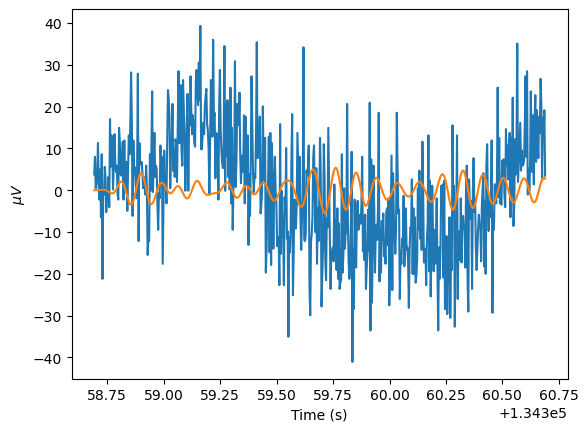

In [16]:
t1_afilt = bp_butter(t1_ndc, Wn=[8, 13])

# we can plot the first channel of the alpha-band filtered data with the raw data for comparison
plt.plot(t1_ndc[:, 0], t1_ndc[:, 1])
plt.plot(t1_afilt[:, 0], t1_afilt[:, 1])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

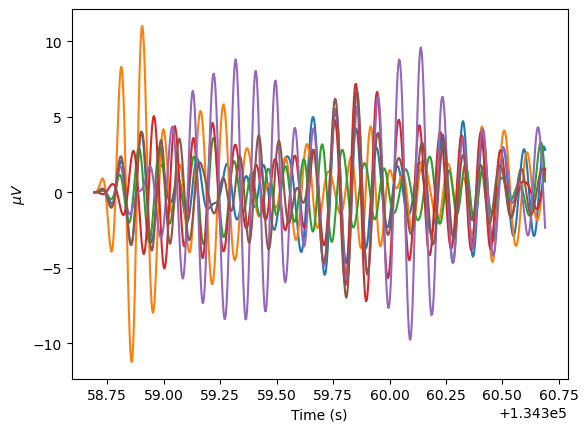

In [17]:
# we can also plot all the alpha-band filtered channels tgth

for i in range(1, t1_afilt.shape[-1]-1):
    plt.plot(t1_afilt[:, 0], t1_afilt[:, i])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

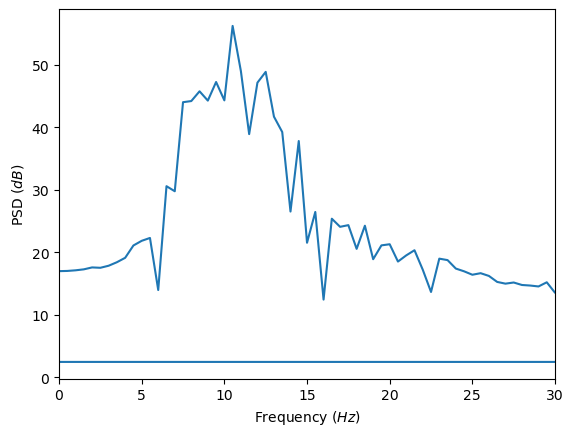

In [18]:
# let's plot the PSD of the alpha-band filtered signal (channel 1 only)


at1_fft = np.fft.fft(t1_afilt[:, 1:], axis=0)
at1_frq = np.fft.fftfreq(t1_afilt.shape[0], 1/Fs)

plt.plot(at1_frq, 10 * np.log10(np.abs(at1_fft[:, 0])**2))

plt.xlim(0, 30)

plt.xlabel(r'Frequency $(Hz)$')
plt.ylabel(r'PSD ($dB$)')

plt.show()

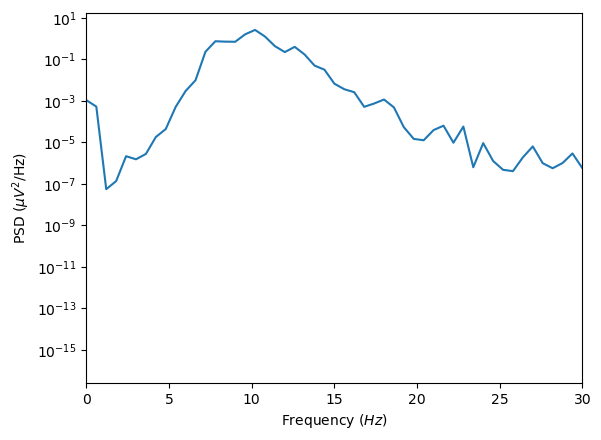

In [19]:
# we can also plot Welch's PSD which is simply windowed to produce a smoother PSD plot

wat1_frq, wat1_psd = signal.welch(t1_afilt[:, 1], Fs, nperseg=500)

plt. semilogy(wat1_frq, wat1_psd)

plt.xlim(0, 30)

plt.xlabel(r'Frequency $(Hz)$')
plt.ylabel(r'PSD ($\mu V^2$/Hz)')

plt.show()

c:\Users\emmac\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


NameError: name 'get_marker_name' is not defined

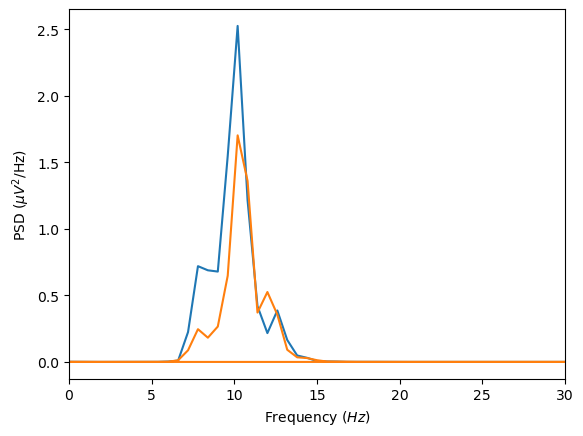

In [20]:
# let's quickly process a trial 1, channel 1 of a motor imagery trial for comparison

mt1       = nodc(motor_im[0, :, :], Fs=Fs)
mt1_afilt = bp_butter(mt1, Wn=[8, 13])

# t1 - baseline
wat1_frq, wat1_psd = signal.welch(t1_afilt[:, 1], Fs, nperseg=500)
plt.plot(wat1_frq, wat1_psd, label='baseline')

# t1 - MI
mwat1_frq,  mwat1_psd = signal.welch(mt1_afilt[:, 1], Fs, nperseg=500)
plt.plot(mwat1_frq, mwat1_psd, label='MI')

plt.xlim(0, 30)

plt.xlabel(r'Frequency $(Hz)$')
plt.ylabel(r'PSD ($\mu V^2$/Hz)')

plt.title(get_marker_name(labels[0]))

# plt.semilogy()

plt.legend()
plt.show()


In [ ]:
# Experimenting with MNE

# MNE takes time samples as no. of columns

In [26]:
t1_afir = mne.filter.filter_data(t1_ndc.T[1:, :], sfreq=Fs, l_freq=8, h_freq=13)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 495 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [27]:
t1_afir.shape

(8, 600)

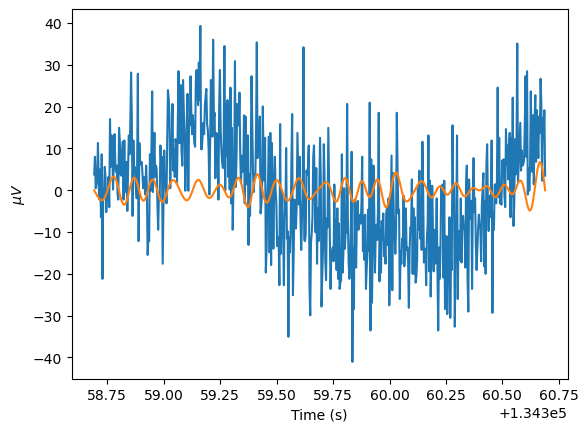

In [28]:
# MNE FIR 'Hamming' window filter

plt.plot(t1_ndc[:, 0], t1_ndc[:, 1])
plt.plot(t1_ndc[:, 0], t1_afir.T[:, 0])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

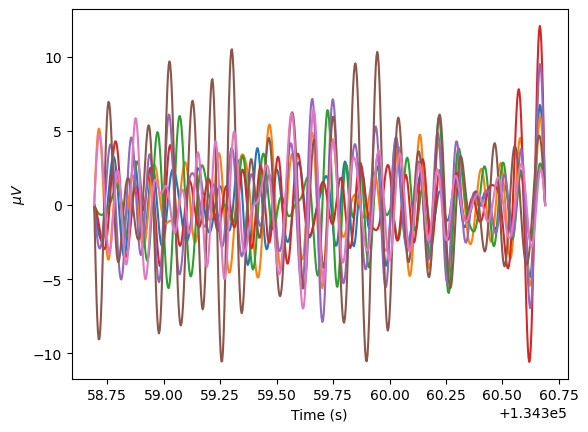

In [29]:
for i in range(7):
    plt.plot(t1_ndc[:, 0], t1_afir.T[:, i])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

In [30]:
t1_aiir = mne.filter.filter_data(t1_ndc.T[1:, :], sfreq=Fs, l_freq=8, h_freq=13, method='iir')

Setting up band-pass filter from 8 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 13.00 Hz: -6.02, -6.02 dB



In [33]:
t1_aiir.shape

(8, 600)

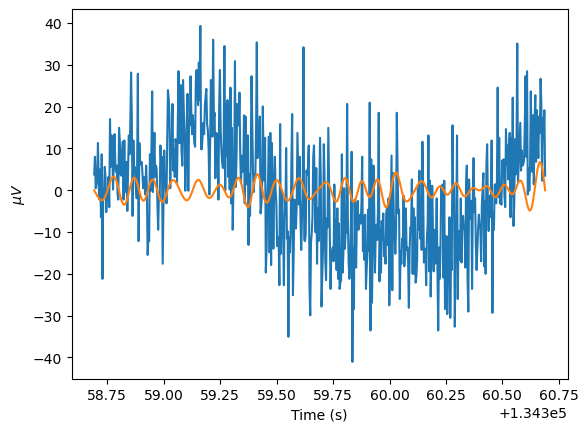

In [31]:
# MNE IIR 'Butterworth' filter

plt.plot(t1_ndc[:, 0], t1_ndc[:, 1])
plt.plot(t1_ndc[:, 0], t1_afir.T[:, 0])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

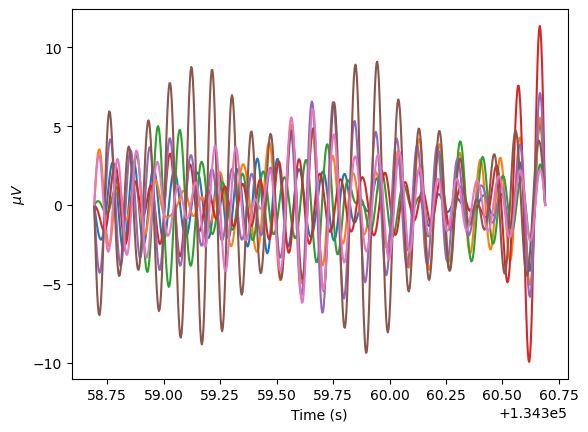

In [32]:
for i in range(7):
    plt.plot(t1_ndc[:, 0], t1_aiir.T[:, i])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()